# Demand Analysis by Time of Day

This notebook analyzes demand patterns from the Uber Hackathon dataset and creates visualizations including heatmaps to estimate demand at different times of day.

## 1. Import Required Libraries

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Load and Explore the Excel File

In [31]:
# Load Excel file and check available sheets
xls = pd.ExcelFile('uber_hackathon_v2_mock_data.xlsx')

print('Available sheets:', xls.sheet_names)
print(f'\nTotal sheets: {len(xls.sheet_names)}')


Available sheets: ['earners', 'riders', 'customers', 'merchants', 'rides_trips', 'eats_orders', 'jobs_like', 'earnings_daily', 'incentives_weekly', 'surge_by_hour', 'cancellation_rates', 'heatmap', 'weather_daily', 'README']

Total sheets: 14


In [32]:
# Load all available dataframes from the Excel file
print("Loading all dataframes from Excel file...")

# Dictionary to store all dataframes
dataframes = {}

# Load each sheet
for sheet_name in xls.sheet_names:
    try:
        df = pd.read_excel(xls, sheet_name=sheet_name)
        dataframes[sheet_name] = df
        print(f"✅ Loaded '{sheet_name}': {df.shape[0]} rows, {df.shape[1]} columns")
    except Exception as e:
        print(f"❌ Error loading '{sheet_name}': {str(e)}")

print(f"\nSuccessfully loaded {len(dataframes)} dataframes:")
for name, df in dataframes.items():
    print(f"  • {name}: {df.shape}")

# Assign commonly used dataframes to variables for easier access
earners = dataframes.get('earners')
riders = dataframes.get('riders') 
customers = dataframes.get('customers')
merchants = dataframes.get('merchants')
rides = dataframes.get('rides_trips')
eats_orders = dataframes.get('eats_orders')
jobs_like = dataframes.get('jobs_like')
earnings_daily = dataframes.get('earnings_daily')
incentives_weekly = dataframes.get('incentives_weekly')
cancellation_rates = dataframes.get('cancellation_rates')
surge_df = dataframes.get('surge_by_hour')
heatmap = dataframes.get('heatmap')
weather_daily = dataframes.get('weather_daily')
rides['start_time'] = pd.to_datetime(rides['start_time'])
rides['end_time'] = pd.to_datetime(rides['end_time'])

print("\n📊 Dataframes ready for analysis!")

Loading all dataframes from Excel file...
✅ Loaded 'earners': 360 rows, 9 columns
✅ Loaded 'riders': 600 rows, 4 columns
✅ Loaded 'customers': 700 rows, 3 columns
✅ Loaded 'merchants': 40 rows, 5 columns
✅ Loaded 'rides_trips': 3000 rows, 24 columns
✅ Loaded 'eats_orders': 2500 rows, 23 columns
✅ Loaded 'jobs_like': 5500 rows, 18 columns
✅ Loaded 'earnings_daily': 5270 rows, 19 columns
✅ Loaded 'incentives_weekly': 3622 rows, 7 columns
✅ Loaded 'surge_by_hour': 120 rows, 3 columns
✅ Loaded 'cancellation_rates': 5453 rows, 4 columns
✅ Loaded 'heatmap': 5453 rows, 8 columns
✅ Loaded 'weather_daily': 605 rows, 3 columns
✅ Loaded 'README': 152 rows, 4 columns

Successfully loaded 14 dataframes:
  • earners: (360, 9)
  • riders: (600, 4)
  • customers: (700, 3)
  • merchants: (40, 5)
  • rides_trips: (3000, 24)
  • eats_orders: (2500, 23)
  • jobs_like: (5500, 18)
  • earnings_daily: (5270, 19)
  • incentives_weekly: (3622, 7)
  • surge_by_hour: (120, 3)
  • cancellation_rates: (5453, 4)
  

In [33]:
drivers = earners[earners['earner_type'] == 'driver']

In [34]:
# Compute time since last ride for each driver
rides['prev_end'] = rides.groupby('driver_id')['end_time'].shift(1)
rides['rest_time_mins'] = (rides['start_time'] - rides['prev_end']).dt.total_seconds() / 60

# Identify breaks longer than a threshold (e.g., 120 mins)
rides['new_shift'] = rides['rest_time_mins'] > 120  # 2 hours break indicates new shift
rides['shift_id'] = rides.groupby('driver_id')['new_shift'].cumsum()


In [35]:
rides = rides.sort_values(['driver_id', 'start_time']).reset_index(drop=True)

def rides_last_3h_per_driver(df):
    times = df['start_time'].to_numpy()
    n = len(times)
    counts = np.zeros(n, dtype=int)
    j = 0
    for i in range(n):
        # advance left pointer until window is within 3 hours
        while times[i] - times[j] > np.timedelta64(3, 'h'):
            j += 1
        counts[i] = i - j        # number of rides in last 3 h before this one
    df = df.copy()
    df['rides_last_3h'] = counts
    return df

rides = (
    rides
    .groupby('driver_id', group_keys=False, sort=False)
    .apply(rides_last_3h_per_driver)
    .reset_index(drop=True)
)



/var/folders/kj/z14x74mn0157q13g6rr82dqr0000gn/T/ipykernel_33321/4073640298.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(rides_last_3h_per_driver)


In [36]:
# Within each shift, compute cumulative driving time
rides['ride_duration_mins'] = (rides['end_time'] - rides['start_time']).dt.total_seconds() / 60
rides['cumulative_minutes'] = rides.groupby(['driver_id','shift_id'])['ride_duration_mins'].cumsum()

# Base fatigue = normalized cumulative minutes
max_shift_minutes = 480  # assume 8h max reasonable
rides['fatigue_base'] = rides['cumulative_minutes'] / max_shift_minutes
rides['fatigue_base'] = rides['fatigue_base'].clip(0, 1)

=== CREATING DRIVER FATIGUE HEATMAP ===



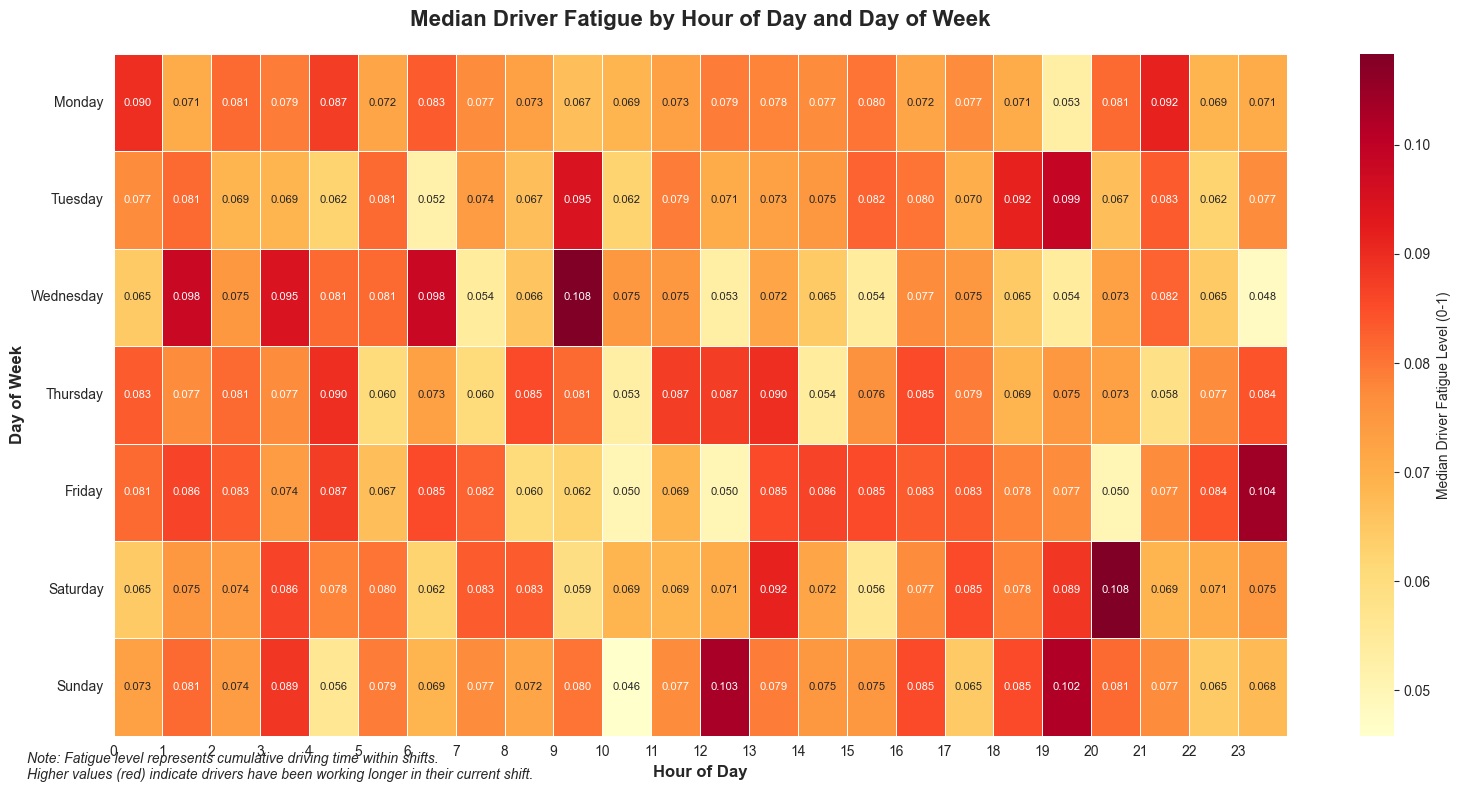


📊 FATIGUE HEATMAP SUMMARY:
Overall median fatigue: 0.075
Peak fatigue time: Wednesday at hour 9
Maximum median fatigue: 0.108
Minimum median fatigue: 0.046

🔥 PEAK FATIGUE HOURS BY DAY:
  Monday: Hour 21 (fatigue: 0.092)
  Tuesday: Hour 19 (fatigue: 0.099)
  Wednesday: Hour 9 (fatigue: 0.108)
  Thursday: Hour 4 (fatigue: 0.090)
  Friday: Hour 23 (fatigue: 0.104)
  Saturday: Hour 20 (fatigue: 0.108)
  Sunday: Hour 12 (fatigue: 0.103)


In [37]:
# Create heatmap of median driver fatigue by hour and day of week
print("=== CREATING DRIVER FATIGUE HEATMAP ===\n")

# Ensure we have the fatigue data calculated
if 'fatigue_base' not in rides.columns:
    print("Calculating fatigue data...")
    # Compute time since last ride for each driver
    rides['prev_end'] = rides.groupby('driver_id')['end_time'].shift(1)
    rides['rest_time_mins'] = (rides['start_time'] - rides['prev_end']).dt.total_seconds() / 60
    
    # Identify breaks longer than a threshold (e.g., 60 mins)
    rides['new_shift'] = rides['rest_time_mins'] > 60
    rides['shift_id'] = rides.groupby('driver_id')['new_shift'].cumsum()
    
    # Within each shift, compute cumulative driving time
    rides['ride_duration_mins'] = (rides['end_time'] - rides['start_time']).dt.total_seconds() / 60
    rides['cumulative_minutes'] = rides.groupby(['driver_id','shift_id'])['ride_duration_mins'].cumsum()
    
    # Base fatigue = normalized cumulative minutes
    max_shift_minutes = 480  # 8 hours max reasonable shift
    rides['fatigue_base'] = rides['cumulative_minutes'] / max_shift_minutes
    rides['fatigue_base'] = rides['fatigue_base'].clip(0, 1)

# Add time features if not already present
rides['hour'] = rides['start_time'].dt.hour
rides['day_of_week'] = rides['start_time'].dt.dayofweek
rides['day_name'] = rides['start_time'].dt.day_name()

# Calculate median fatigue by hour and day of week
fatigue_heatmap_data = rides.groupby(['day_of_week', 'hour'])['fatigue_base'].median().reset_index()

# Pivot to create heatmap format
fatigue_pivot = fatigue_heatmap_data.pivot(index='day_of_week', columns='hour', values='fatigue_base')

# Map day numbers to day names for better readability
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
fatigue_pivot.index = [day_names[i] for i in fatigue_pivot.index]

# Create the heatmap
plt.figure(figsize=(16, 8))

# Create heatmap with custom colormap
sns.heatmap(fatigue_pivot, 
            annot=True, 
            fmt='.3f',
            cmap='YlOrRd',
            cbar_kws={'label': 'Median Driver Fatigue Level (0-1)'},
            linewidths=0.5,
            annot_kws={'size': 8})

plt.title('Median Driver Fatigue by Hour of Day and Day of Week', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Hour of Day', fontsize=12, fontweight='bold')
plt.ylabel('Day of Week', fontsize=12, fontweight='bold')
plt.xticks(range(0, 24), labels=range(0, 24))
plt.yticks(rotation=0)

# Add text annotations for interpretation
plt.figtext(0.02, 0.02, 
           'Note: Fatigue level represents cumulative driving time within shifts.\n' +
           'Higher values (red) indicate drivers have been working longer in their current shift.',
           fontsize=10, style='italic')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n📊 FATIGUE HEATMAP SUMMARY:")
print(f"Overall median fatigue: {rides['fatigue_base'].median():.3f}")
print(f"Peak fatigue time: {fatigue_pivot.max(axis=1).idxmax()} at hour {fatigue_pivot.max(axis=0).idxmax()}")
print(f"Maximum median fatigue: {fatigue_pivot.max().max():.3f}")
print(f"Minimum median fatigue: {fatigue_pivot.min().min():.3f}")

# Show peak fatigue hours for each day
print(f"\n🔥 PEAK FATIGUE HOURS BY DAY:")
for day in fatigue_pivot.index:
    peak_hour = fatigue_pivot.loc[day].idxmax()
    peak_value = fatigue_pivot.loc[day].max()
    print(f"  {day}: Hour {peak_hour} (fatigue: {peak_value:.3f})")

In [38]:
rides['fatigue_intensity'] = rides['fatigue_base'] + 0.1 * rides['rides_last_3h']
rides['fatigue_intensity'] = rides['fatigue_intensity'].clip(0, 1)

rides['night_penalty'] = rides['hour'].apply(lambda x: 0.2 if x >= 23 or x <= 5 else 0)
rides['fatigue_final']  = (rides['fatigue_intensity'] + rides['night_penalty']).clip(0, 1)


In [39]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# assume `rides` already has fatigue_final, fare_amount, surge_multiplier, etc.

# define fatigue penalty weight
lambda_fatigue = 50  # tune this later
rides['effective_reward'] = rides['fare_amount'] - lambda_fatigue * rides['fatigue_final']

# select features (example subset)
feature_cols = [
    'hour', 'day_of_week', 'city_id',
    'distance_km', 'duration_mins', 'surge_multiplier',
    'fatigue_final'
]

X = rides[feature_cols]
y = rides['effective_reward']

# one-hot encode categorical features
X = pd.get_dummies(X, columns=['city_id', 'day_of_week'], drop_first=True)

# normalize numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, shuffle=False
)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

model = Sequential([
    Dense(128, activation='relu', input_shape=(X_scaled.shape[1],)),
    BatchNormalization(),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(1)  # predicted effective reward
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='mse')

history = model.fit(
    X_scaled, y,
    validation_split=0.2,
    epochs=50,
    batch_size=256,
    verbose=1
)


Epoch 1/50


/Users/kira/Documents/pycharm_projects/junction/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 67.7664 - val_loss: 74.7065
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 44.5105 - val_loss: 65.8971
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 27.1297 - val_loss: 55.5900
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 14.0922 - val_loss: 45.2914
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 8.5637 - val_loss: 38.0949
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6.5526 - val_loss: 35.5528
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.2415 - val_loss: 34.6428
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.8558 - val_loss: 33.5718
Epoch 9/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.5748 - val_loss: 32.5822
Epoch 10/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.6724 - val_loss: 30.9295
Epoch 11/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 5.4527 - val_loss: 29.6539
Epoch 12/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss:

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
RMSE: 1.95


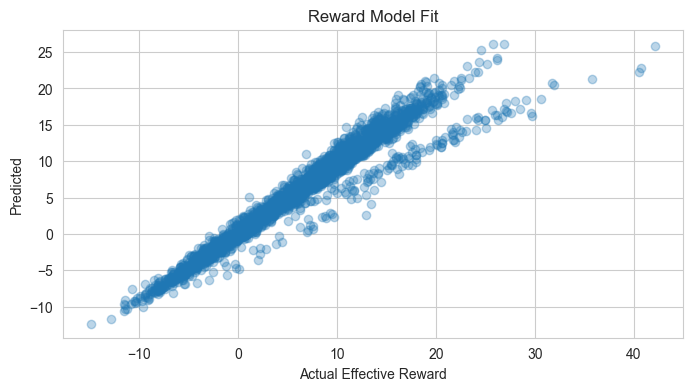

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error

y_pred = model.predict(X_scaled).flatten()
rmse = root_mean_squared_error(y, y_pred)
print(f"RMSE: {rmse:.2f}")

plt.figure(figsize=(8,4))
plt.scatter(y, y_pred, alpha=0.3)
plt.xlabel("Actual Effective Reward")
plt.ylabel("Predicted")
plt.title("Reward Model Fit")
plt.show()


In [ ]:
# define baseline expected reward for "rest"
# rest reduces fatigue but yields no fare
rest_penalty = 0  # direct earnings = 0
recovery_rate = 0.15  # fatigue reduction per 30 min rest
rides['rest_expected_reward'] = -rides['fatigue_final'] * lambda_fatigue * recovery_rate

# define "relocate" action (simple version: average reward in nearby area)
rides['relocate_expected_reward'] = (
    rides.groupby('city_id')['effective_reward'].transform('mean') * 0.8  # penalize relocation time
)

rides['take_ride_expected_reward'] = model.predict(X_scaled).flatten()

rides['best_action'] = rides[['take_ride_expected_reward',
                              'rest_expected_reward',
                              'relocate_expected_reward']].idxmax(axis=1)

recommendations = rides[['driver_id', 'hour', 'city_id', 'fatigue_final', 'best_action']]
print(recommendations.head())


94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
  driver_id  hour  city_id  fatigue_final                best_action
0    E10000    15        4       0.070833  take_ride_expected_reward
1    E10000    16        4       0.083333  take_ride_expected_reward
2    E10000    23        4       0.239583   relocate_expected_reward
3    E10000     9        4       0.060417  take_ride_expected_reward
4    E10000    19        4       0.070833  take_ride_expected_reward


In [ ]:
print("=== DATAFRAME HEADS ===\n")

for name, df in dataframes.items():
    print(f"📊 {name.upper()}:")
    print(f"Shape: {df.shape}")
    print(df.head())
    print("-" * 80)
    print()

In [ ]:

# Create a comprehensive merged dataframe with all relevant data
print("=== CREATING COMPREHENSIVE MERGED DATAFRAME ===\n")

# Start with the rides dataframe as the base
merged_df = rides.copy()

# Convert datetime columns to proper format
merged_df['start_time'] = pd.to_datetime(merged_df['start_time'])
merged_df['end_time'] = pd.to_datetime(merged_df['end_time'])
merged_df['date'] = pd.to_datetime(merged_df['date'])

# Add time-based features for merging
merged_df['hour'] = merged_df['start_time'].dt.hour
merged_df['day_of_week'] = merged_df['start_time'].dt.dayofweek
merged_df['day_name'] = merged_df['start_time'].dt.day_name()

# 1. Merge with driver/earner information
print("1. Merging with driver information...")
merged_df = merged_df.merge(
    earners[earners['earner_type'] == 'driver'], 
    left_on='driver_id', 
    right_on='earner_id', 
    how='left',
    suffixes=('_ride', '_driver')
)

# 2. Merge with weather data
print("2. Merging with weather data...")
weather_daily['date'] = pd.to_datetime(weather_daily['date'])
merged_df = merged_df.merge(
    weather_daily,
    on=['date', 'city_id'],
    how='left'
)

# 3. Add surge multiplier data by city and hour
print("3. Merging with surge data...")
merged_df = merged_df.merge(
    surge_df,
    on=['city_id', 'hour'],
    how='left',
    suffixes=('', '_surge_baseline')
)


# 5. Add earnings and cancellation data (aggregated by driver and date)
print("5. Adding daily earnings data...")
earnings_daily['date'] = pd.to_datetime(earnings_daily['date'])
merged_df = merged_df.merge(
    earnings_daily,
    left_on=['driver_id', 'date'],
    right_on=['earner_id', 'date'],
    how='left',
    suffixes=('', '_daily')
)



# Clean up duplicate columns and rename for clarity
print("7. Cleaning up columns...")
columns_to_keep = [
    # Trip identification
    'ride_id', 'driver_id', 'rider_id', 'city_id',
    
    # Trip details
    'product', 'vehicle_type_ride', 'is_ev_ride', 'start_time', 'end_time', 'date',
    'pickup_lat', 'pickup_lon', 'pickup_hex_id9', 'drop_lat', 'drop_lon', 'drop_hex_id9',
    'distance_km', 'duration_mins', 'hour', 'day_of_week', 'day_name',
    
    # Financial
    'surge_multiplier', 'fare_amount', 'uber_fee', 'net_earnings', 'tips', 'payment_type',
    
    # Driver information
    'earner_type', 'vehicle_type_driver', 'fuel_type', 'is_ev_driver', 
    'experience_months', 'rating', 'status', 'home_city_id',
    
    
    # External factors
    'weather',
    
    # Performance metrics
    'daily_rides', 'daily_earnings', 'daily_online_hours',
    'cancellation_rate', 'acceptance_rate'
]

# Select only the columns that exist in our merged dataframe
available_columns = [col for col in columns_to_keep if col in merged_df.columns]
final_df = merged_df[available_columns].copy()

print(f"✅ Successfully created merged dataframe!")
print(f"📊 Final shape: {final_df.shape}")
print(f"📋 Columns: {len(final_df.columns)}")

print(f"\n📋 FINAL COLUMNS:")
for i, col in enumerate(final_df.columns, 1):
    print(f"  {i:2d}. {col}")

print(f"\n📊 SAMPLE DATA:")
print(final_df.head())

print(f"\n📈 DATA TYPES:")
print(final_df.dtypes)

print(f"\n🔍 NULL VALUES:")
null_counts = final_df.isnull().sum()
print(null_counts[null_counts > 0])

In [ ]:
gb = final_df.groupby('start_time')


In [ ]:
# Step 1: Select a specific driver to analyze
# Let's pick the most active driver from our earlier analysis
driver_to_analyze =   # You can change this to any driver ID

print(f"=== ANALYZING DRIVER: {driver_to_analyze} ===\n")

# Step 2: Filter the dataframe for this specific driver
single_driver_df = rides_df[rides_df['driver_id'] == driver_to_analyze].copy()

# Step 3: Basic statistics about this driver
print(f"📊 BASIC STATISTICS:")
print(f"  • Total rides: {len(single_driver_df)}")
print(f"  • Active days: {single_driver_df['date'].nunique()}")
print(f"  • Date range: {single_driver_df['date'].min().date()} to {single_driver_df['date'].max().date()}")
print(f"  • Total distance: {single_driver_df['distance_km'].sum():.2f} km")
print(f"  • Total ride time: {single_driver_df['duration_mins'].sum():.0f} minutes ({single_driver_df['duration_mins'].sum()/60:.1f} hours)")
print(f"  • Average ride duration: {single_driver_df['duration_mins'].mean():.1f} minutes")
print(f"  • Average ride distance: {single_driver_df['distance_km'].mean():.2f} km")
print(f"  • Longest ride: {single_driver_df['duration_mins'].max():.0f} minutes")
print(f"  • Shortest ride: {single_driver_df['duration_mins'].min():.0f} minutes")

# Step 4: Look at the first few rides
print(f"\n📋 FIRST 5 RIDES:")
print(single_driver_df[['date', 'start_time', 'end_time', 'duration_mins', 'distance_km', 'fare_amount']].head())

print(f"\n📋 LAST 5 RIDES:")
print(single_driver_df[['date', 'start_time', 'end_time', 'duration_mins', 'distance_km', 'fare_amount']].tail())

In [ ]:
# Analyze this driver's hourly patterns
print(f"=== HOURLY ACTIVITY PATTERN FOR DRIVER {driver_to_analyze} ===\n")

# Group by hour to see when this driver works
hourly_pattern = single_driver_df.groupby('hour').agg({
    'ride_id': 'count',
    'duration_mins': ['sum', 'mean'],
    'distance_km': ['sum', 'mean'],
    'fare_amount': 'sum'
}).round(2)

hourly_pattern.columns = ['num_rides', 'total_duration', 'avg_duration', 
                          'total_distance', 'avg_distance', 'total_earnings']

print("Rides by Hour of Day:")
print(hourly_pattern)

# Find peak hours
print(f"\n🔥 PEAK HOURS:")
print(f"  • Most rides: Hour {hourly_pattern['num_rides'].idxmax()} ({hourly_pattern['num_rides'].max():.0f} rides)")
print(f"  • Longest total duration: Hour {hourly_pattern['total_duration'].idxmax()} ({hourly_pattern['total_duration'].max():.0f} minutes)")
print(f"  • Highest earnings: Hour {hourly_pattern['total_earnings'].idxmax()} (€{hourly_pattern['total_earnings'].max():.2f})")

In [ ]:
# Analyze day-of-week patterns
print(f"=== DAY OF WEEK PATTERN FOR DRIVER {driver_to_analyze} ===\n")

daily_pattern = single_driver_df.groupby('day_name').agg({
    'ride_id': 'count',
    'duration_mins': 'sum',
    'fare_amount': 'sum'
}).round(2)

daily_pattern.columns = ['num_rides', 'total_duration_mins', 'total_earnings']

# Sort by day of week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_pattern = daily_pattern.reindex([d for d in day_order if d in daily_pattern.index])

print("Rides by Day of Week:")
print(daily_pattern)

print(f"\n📅 DAY PATTERNS:")
print(f"  • Busiest day: {daily_pattern['num_rides'].idxmax()} ({daily_pattern['num_rides'].max():.0f} rides)")
print(f"  • Slowest day: {daily_pattern['num_rides'].idxmin()} ({daily_pattern['num_rides'].min():.0f} rides)")
print(f"  • Best earning day: {daily_pattern['total_earnings'].idxmax()} (€{daily_pattern['total_earnings'].max():.2f})")

In [ ]:
# Visualize this driver's activity
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Rides by hour
axes[0, 0].bar(hourly_pattern.index, hourly_pattern['num_rides'], color='#2E86AB', alpha=0.8)
axes[0, 0].set_xlabel('Hour of Day', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Number of Rides', fontsize=11, fontweight='bold')
axes[0, 0].set_title(f'Driver {driver_to_analyze}: Rides by Hour of Day', fontsize=13, fontweight='bold')
axes[0, 0].grid(axis='y', alpha=0.3)
axes[0, 0].set_xticks(range(0, 24))

# Plot 2: Total duration by hour
axes[0, 1].bar(hourly_pattern.index, hourly_pattern['total_duration'], color='#F77F00', alpha=0.8)
axes[0, 1].set_xlabel('Hour of Day', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('Total Ride Duration (minutes)', fontsize=11, fontweight='bold')
axes[0, 1].set_title(f'Driver {driver_to_analyze}: Total Work Time by Hour', fontsize=13, fontweight='bold')
axes[0, 1].grid(axis='y', alpha=0.3)
axes[0, 1].set_xticks(range(0, 24))
axes[0, 1].axhline(y=60, color='red', linestyle='--', linewidth=1.5, alpha=0.5, label='60 min threshold')
axes[0, 1].legend()

# Plot 3: Rides by day of week
axes[1, 0].bar(range(len(daily_pattern)), daily_pattern['num_rides'], color='#06A77D', alpha=0.8)
axes[1, 0].set_xlabel('Day of Week', fontsize=11, fontweight='bold')
axes[1, 0].set_ylabel('Number of Rides', fontsize=11, fontweight='bold')
axes[1, 0].set_title(f'Driver {driver_to_analyze}: Rides by Day of Week', fontsize=13, fontweight='bold')
axes[1, 0].set_xticks(range(len(daily_pattern)))
axes[1, 0].set_xticklabels(daily_pattern.index, rotation=45)
axes[1, 0].grid(axis='y', alpha=0.3)

# Plot 4: Earnings by day of week
axes[1, 1].bar(range(len(daily_pattern)), daily_pattern['total_earnings'], color='#D62828', alpha=0.8)
axes[1, 1].set_xlabel('Day of Week', fontsize=11, fontweight='bold')
axes[1, 1].set_ylabel('Total Earnings (€)', fontsize=11, fontweight='bold')
axes[1, 1].set_title(f'Driver {driver_to_analyze}: Earnings by Day of Week', fontsize=13, fontweight='bold')
axes[1, 1].set_xticks(range(len(daily_pattern)))
axes[1, 1].set_xticklabels(daily_pattern.index, rotation=45)
axes[1, 1].grid(axis='y', alpha=0.3)

plt.suptitle(f'Single Driver Analysis: {driver_to_analyze}', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

In [ ]:
# Advanced analysis: Look at specific days
print(f"=== DETAILED DAILY BREAKDOWN FOR DRIVER {driver_to_analyze} ===\n")

# Get rides per day
rides_per_day = single_driver_df.groupby('date').agg({
    'ride_id': 'count',
    'duration_mins': 'sum',
    'distance_km': 'sum',
    'fare_amount': 'sum'
}).round(2)

rides_per_day.columns = ['num_rides', 'total_duration_mins', 'total_distance_km', 'total_earnings']

print("Sample of daily activity (first 10 days):")
print(rides_per_day.head(10))

# Find best and worst days
print(f"\n🏆 BEST DAYS:")
print(f"\nMost rides in a day:")
best_day = rides_per_day['num_rides'].idxmax()
print(f"  Date: {best_day.date()}")
print(f"  Rides: {rides_per_day.loc[best_day, 'num_rides']:.0f}")
print(f"  Total duration: {rides_per_day.loc[best_day, 'total_duration_mins']:.0f} minutes")
print(f"  Total earnings: €{rides_per_day.loc[best_day, 'total_earnings']:.2f}")

print(f"\nHighest earnings in a day:")
best_earning_day = rides_per_day['total_earnings'].idxmax()
print(f"  Date: {best_earning_day.date()}")
print(f"  Rides: {rides_per_day.loc[best_earning_day, 'num_rides']:.0f}")
print(f"  Total earnings: €{rides_per_day.loc[best_earning_day, 'total_earnings']:.2f}")

# Average stats per working day
print(f"\n📊 AVERAGE PER WORKING DAY:")
print(f"  Rides: {rides_per_day['num_rides'].mean():.1f}")
print(f"  Duration: {rides_per_day['total_duration_mins'].mean():.1f} minutes")
print(f"  Distance: {rides_per_day['total_distance_km'].mean():.1f} km")
print(f"  Earnings: €{rides_per_day['total_earnings'].mean():.2f}")

In [ ]:
# Example: Analyze a specific day in detail
# Pick the day with most rides
target_date = rides_per_day['num_rides'].idxmax()

print(f"=== DETAILED ANALYSIS: {driver_to_analyze} ON {target_date.date()} ===\n")

# Get all rides for this specific day
day_rides = single_driver_df[single_driver_df['date'] == target_date].sort_values('start_time').copy()

# Ensure datetime columns are properly parsed
day_rides['start_time'] = pd.to_datetime(day_rides['start_time'])
day_rides['end_time'] = pd.to_datetime(day_rides['end_time'])

print(f"Number of rides: {len(day_rides)}")
print(f"\nAll rides on this day:\n")

# Show each ride with details
for idx, ride in day_rides.iterrows():
    print(f"Ride {idx}:")
    print(f"  Time: {ride['start_time'].strftime('%H:%M')} → {ride['end_time'].strftime('%H:%M')} "
          f"({ride['duration_mins']:.0f} min)")
    print(f"  Distance: {ride['distance_km']:.2f} km")
    print(f"  Fare: €{ride['fare_amount']:.2f}")
    print(f"  Product: {ride['product']}")
    print()

# Calculate break times between rides
if len(day_rides) > 1:
    print("⏰ BREAK TIMES BETWEEN RIDES:")
    day_rides_sorted = day_rides.sort_values('start_time').copy()
    for i in range(len(day_rides_sorted) - 1):
        current_ride = day_rides_sorted.iloc[i]
        next_ride = day_rides_sorted.iloc[i + 1]
        
        break_time = (next_ride['start_time'] - current_ride['end_time']).total_seconds() / 60
        
        print(f"  Between ride ending at {current_ride['end_time'].strftime('%H:%M')} "
              f"and ride starting at {next_ride['start_time'].strftime('%H:%M')}: "
              f"{break_time:.0f} minutes")
    
    # Calculate average break
    breaks = []
    for i in range(len(day_rides_sorted) - 1):
        break_mins = (day_rides_sorted.iloc[i + 1]['start_time'] - 
                     day_rides_sorted.iloc[i]['end_time']).total_seconds() / 60
        breaks.append(break_mins)
    
    print(f"\n  Average break time: {np.mean(breaks):.0f} minutes")

In [ ]:
# More examples: Different ways to filter and analyze the single driver data

print(f"=== ADDITIONAL FILTERING EXAMPLES FOR DRIVER {driver_to_analyze} ===\n")

# Example 1: Filter by time period
print("1️⃣ MORNING RIDES (6 AM - 12 PM):")
morning_rides = single_driver_df[single_driver_df['hour'].between(6, 11)]
print(f"   Number of morning rides: {len(morning_rides)}")
print(f"   Total morning earnings: €{morning_rides['fare_amount'].sum():.2f}")

# Example 2: Filter by product type
print(f"\n2️⃣ RIDES BY PRODUCT TYPE:")
product_breakdown = single_driver_df.groupby('product').agg({
    'ride_id': 'count',
    'fare_amount': 'sum'
}).round(2)
product_breakdown.columns = ['num_rides', 'total_earnings']
print(product_breakdown)

# Example 3: Filter by distance
print(f"\n3️⃣ LONG DISTANCE RIDES (>10 km):")
long_rides = single_driver_df[single_driver_df['distance_km'] > 10]
print(f"   Number of long rides: {len(long_rides)}")
print(f"   Average fare for long rides: €{long_rides['fare_amount'].mean():.2f}")

# Example 4: Filter by specific city
if 'city_id' in single_driver_df.columns:
    print(f"\n4️⃣ RIDES BY CITY:")
    city_breakdown = single_driver_df.groupby('city_id').agg({
        'ride_id': 'count',
        'fare_amount': 'sum'
    }).round(2)
    city_breakdown.columns = ['num_rides', 'total_earnings']
    print(city_breakdown)

# Example 5: Filter by surge multiplier
print(f"\n5️⃣ SURGE PRICING ANALYSIS:")
surge_rides = single_driver_df[single_driver_df['surge_multiplier'] > 1.0]
normal_rides = single_driver_df[single_driver_df['surge_multiplier'] == 1.0]
print(f"   Rides with surge pricing: {len(surge_rides)} ({len(surge_rides)/len(single_driver_df)*100:.1f}%)")
print(f"   Normal pricing rides: {len(normal_rides)} ({len(normal_rides)/len(single_driver_df)*100:.1f}%)")
if len(surge_rides) > 0:
    print(f"   Average surge multiplier: {surge_rides['surge_multiplier'].mean():.2f}x")
    print(f"   Max surge multiplier: {surge_rides['surge_multiplier'].max():.2f}x")

# Example 6: Weekend vs Weekday
print(f"\n6️⃣ WEEKEND VS WEEKDAY:")
weekend = single_driver_df[single_driver_df['day_of_week'].isin([5, 6])]  # Saturday, Sunday
weekday = single_driver_df[~single_driver_df['day_of_week'].isin([5, 6])]
print(f"   Weekend rides: {len(weekend)} (avg earnings: €{weekend['fare_amount'].mean():.2f})")
print(f"   Weekday rides: {len(weekday)} (avg earnings: €{weekday['fare_amount'].mean():.2f})")

print(f"\n💡 TIP: You can combine multiple filters using & (and) or | (or)")
print(f"   Example: morning_weekend = df[(df['hour'].between(6,11)) & (df['day_of_week']==6)]")

### Summary: How to Analyze a Single Driver

**Step 1: Filter the DataFrame**
```python
single_driver_df = rides_df[rides_df['driver_id'] == 'DRIVER_ID'].copy()
```

**Step 2: Perform Analysis**
- Basic stats: `.describe()`, `.sum()`, `.mean()`, etc.
- Group by time: `.groupby('hour')` or `.groupby('date')`
- Filter conditions: `df[df['column'] > value]`
- Combine filters: `df[(condition1) & (condition2)]`

**Step 3: Visualize**
- Use matplotlib/seaborn for charts
- Create custom plots based on groupby results

**Key Techniques:**
1. **Temporal analysis**: Group by hour, day, week
2. **Product analysis**: Group by product type, city
3. **Financial analysis**: Sum earnings, calculate averages
4. **Workload analysis**: Count rides, sum durations
5. **Comparative analysis**: Weekend vs weekday, surge vs normal

This approach works for any driver in the dataset - just change the `driver_id`!